In [28]:
import jax.numpy as jnp
import numpy as np
import copy
from jax import random


import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

rng_key = random.PRNGKey(1)

In [29]:
class TeamMember:

    def __init__(self, id, theta):
        self.id = id
        self.theta = theta
        self.N = 0
        self.reward = 0

    def update(self, achieved_reward):
        self.N += 1
        self.reward += achieved_reward

    def __repr__(self):
        return f"ID: {self.id} | theta: {self.theta} | Used number: {self.N} | Obtained rewards: {self.reward}"


class Oracle:
    @classmethod
    def get_best_member(cls, environment) -> TeamMember:
        highest = None
        for t in environment.team_members:
            if(highest == None):
                highest = t
            else:
                if(highest.theta < t.theta):
                    highest = t
        return highest


class Environment:
    
    def __init__(self, thetas: np.array, delta: np.float32):

        self.delta = delta # defines the task complexity for the simulation

        self.accumulated_rewards = []
        self.estimated_thetas = np.zeros(thetas.shape)
        self.usage_counts = np.zeros(thetas.shape)

        self.estimated_thetas_history = [copy.deepcopy(self.estimated_thetas)]
        self.usage_count_history = [copy.deepcopy(self.usage_counts)]
        self.used_member_history = []

        self.num_team_members = len(thetas)
        
        self.team_members = []
        for i in range(len(thetas)):
            self.team_members.append(TeamMember(i, thetas[i]))


    def update(self, used_team_member:TeamMember, reward):
        idx = used_team_member.id
        self.usage_counts[idx] += 1
        self.accumulated_rewards.append(reward)
        self.used_member_history.append(used_team_member.id)
        
        self.estimated_thetas[idx] = ((self.usage_counts[idx] - 1) * self.estimated_thetas[idx] + reward) / self.usage_counts[idx]

        self.estimated_thetas_history.append(copy.deepcopy(self.estimated_thetas))
        self.usage_count_history.append(copy.deepcopy(self.usage_counts))


    def _get_completion_probability(self, beta, delta):
        return jnp.exp(beta - delta) / (1 + jnp.exp(beta-delta))
    
    def assign_task_and_get_reward(self, team_member: TeamMember):
        
        # simulating team member performing the task
        team_member_true_theta = team_member.theta
        completion_probability = self._get_completion_probability(team_member_true_theta, self.delta)
        outcome = np.random.rand() < completion_probability
        reward = 1 if outcome else 0

        team_member.update(reward)

        return reward

# Bandit selection method
class EpsilonGreedy:
    @classmethod
    def get_team_member(cls, env: Environment, eps: float=0.1) -> TeamMember:
        # Decide to either explore or exploit
        if np.random.random() < eps:
            arm = np.random.randint(env.num_team_members)
        else:
            arm = np.argmax(env.estimated_thetas)
        return env.team_members[arm]

## ENVIRONMENT VARIABLES ARE DEFINED HERE.

In [30]:
EPS = 0.3
NUMBER_OF_TRIALS = 1000
DELTA = 0.6

THETAS = [0.3, 0.5, 0.8]

environment = Environment(np.array(THETAS), DELTA)

In [31]:
for t in range(NUMBER_OF_TRIALS):

    # select a team member
    selected_member = EpsilonGreedy.get_team_member(environment, EPS)
    
    # perform the action and get the reward
    reward = environment.assign_task_and_get_reward(selected_member)

    # update the states
    environment.update(selected_member, reward)

 
print(environment.estimated_thetas, sum(environment.accumulated_rewards))

[0.44329897 0.47191011 0.55036855] 533


In [32]:
opt_rewards = []
for i in range(NUMBER_OF_TRIALS):
    best_member = Oracle.get_best_member(environment)

    reward = environment.assign_task_and_get_reward(selected_member)
    opt_rewards.append(reward)

print(sum(opt_rewards))

568


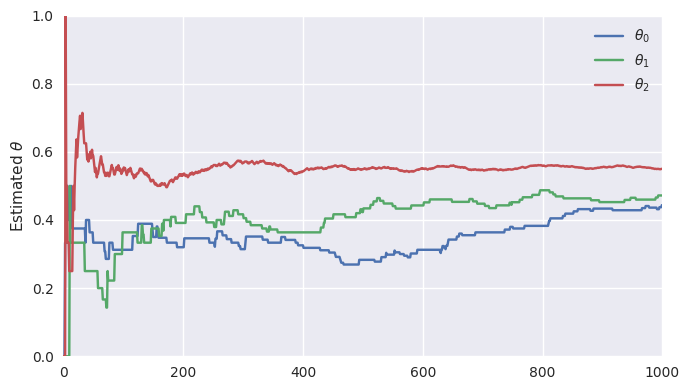

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

theta_evolution = np.array(environment.estimated_thetas_history)

# Plot the estimated theta values
for i in range(environment.num_team_members):
    ax.plot(theta_evolution[:, i], label=r"$\theta_{}$".format(i))

ax.legend()

ax.set_ylabel(r"Estimated $\theta$")

plt.xlim([0, 1000])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

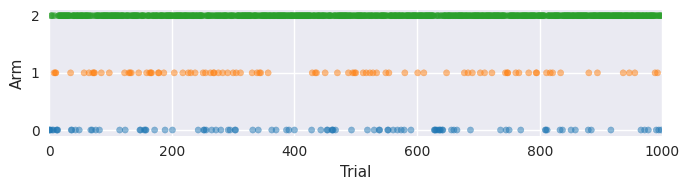

In [34]:
# Plot a scatter plot of which arm was chosen at each time step
arm_index = [0, 1, 2]
arm_labels = ["0", "1", "2"]
arm_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Plot the arm choices

fig, ax = plt.subplots(1, 1, figsize=(7, 2))

ax.scatter(range(NUMBER_OF_TRIALS), environment.used_member_history, c=[arm_colors[i] for i in environment.used_member_history], s=20, alpha=0.5)
ax.set_yticks(arm_index, arm_labels)
ax.set_ylabel("Arm")
ax.set_xlabel("Trial")
ax.set_xlim([0, 1000])
plt.tight_layout()
plt.show()

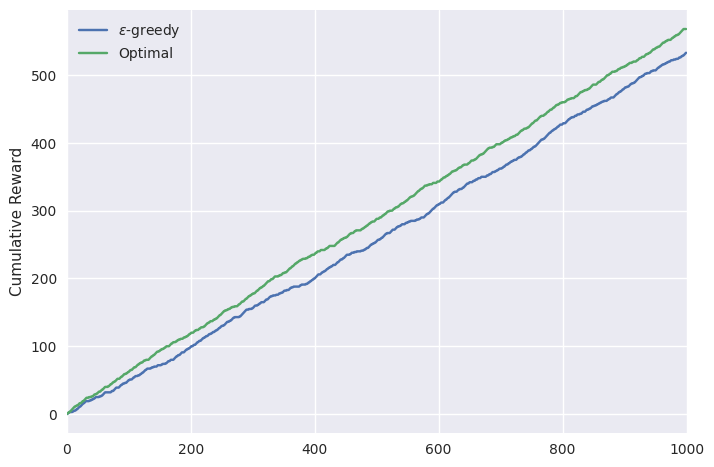

In [35]:
plt.plot(np.cumsum(environment.accumulated_rewards), label=r"$\epsilon$-greedy")
plt.plot(np.cumsum(opt_rewards), label=r"Optimal")
plt.legend()
plt.ylabel("Cumulative Reward")
plt.xlim([0, 1000])

plt.show()

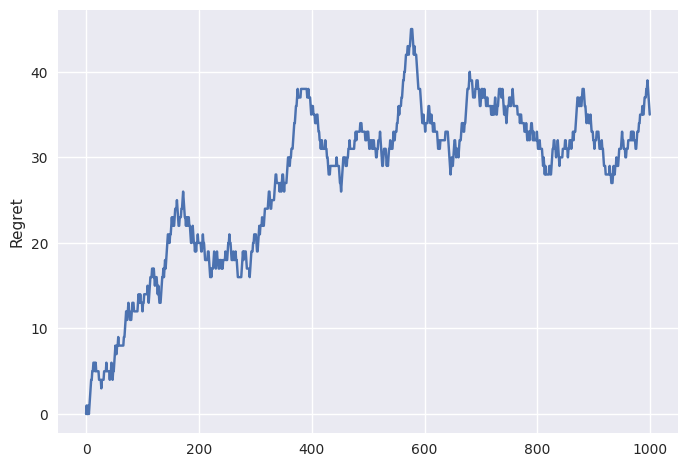

In [36]:
regrets = np.cumsum(opt_rewards) - np.cumsum(environment.accumulated_rewards)
plt.plot(regrets)
plt.ylabel("Regret")
plt.show()